### Justin R McClain
Tuning our GAN   


## Dependencies

### Installation

In [2]:
# Install necessary packages for generating GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-dcaf4hzo
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-dcaf4hzo
  Resolved https://github.com/tensorflow/docs to commit af33301a434ea70e104865b9d2e93e230494c1cb
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184142 sha256=c4ae75dafe1733d045047bfb2cde325cdc325e73a1977b2ca8ae0adfa116b2a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-lmnrs36a/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


### Imports

In [3]:
# Standard library imports
import glob
import os
import time

# Third-party imports for data handling and visualization
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import layers

# IPython display for dynamic outputs in Jupyter
from IPython import display


## Data Preparation

In [4]:
# Constants for data buffering and batching
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Load and preprocess training data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize images to [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


11490434/11490434 [==============================] - 0s 0us/step


## Models

### Generator Model

In [5]:
def make_generator_model():
    """
    Creates the generator model for the GAN.
    Returns:
        A TensorFlow Keras Sequential model.
    """

    model = tf.keras.Sequential()
    # Initial fully connected layer (7x7 as it's a fraction of 28X28 for sampling)
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    # Stacked Convolutional Layers
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)  # MNIST dimensions

    return model

generator = make_generator_model()


#### Generate initial Image  

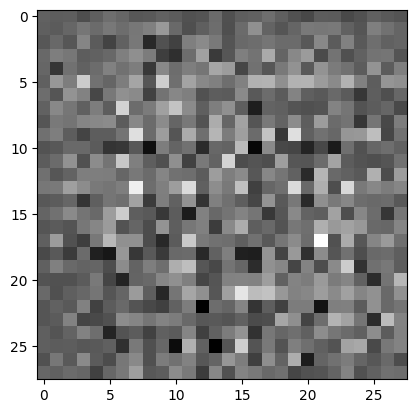

In [6]:
# Generate an initial image using the untrained generator
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator Model

In [7]:
def make_discriminator_model():
    """
    Creates the discriminator model for the GAN.
    Returns:
        A TensorFlow Keras Sequential model.
    """

    model = tf.keras.Sequential()

    # Added layer normalization at each layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same' ,input_shape=[28, 28, 1]))
    model.add(layers.LayerNormalization())

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LayerNormalization())

    # Added a 256 layer for further downsampling
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LayerNormalization())

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[0.54372716]], shape=(1, 1), dtype=float32)


## Loss Functions

### Discriminator Loss

In [8]:
def discriminator_loss(real_output, fake_output):
    """
    Computes the discriminator's loss.
    It measures how well the discriminator is able to distinguish real images from fakes.
    It compares the discriminator's predictions on real images to an array of 1s,
    and the discriminator's predictions on fake (generated) images to an array of 0s.
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator Loss

In [9]:
def generator_loss(fake_output):
    """
    Computes the generator's loss.
    It measures how well the generator was able to trick the discriminator.
    Intuitively, if the generator is performing well, the discriminator will classify
    the fake images as real (or 1).
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Feature Matching Loss

In [10]:
def feature_matching_loss(real_images, fake_images, discriminator):
    """
    Feature matching loss to improve the stability of the generator.
    This is an additional loss for the generator and minimizes the differences
    in feature representations between real and generated images.
    """
    # Extract intermediate layer outputs from the discriminator
    intermediate_layer_model = tf.keras.Model(inputs=discriminator.input,
                                              outputs=discriminator.layers[-5].output)
    real_features = intermediate_layer_model(real_images, training=False)
    fake_features = intermediate_layer_model(fake_images, training=False)

    # Ensure the batch sizes are the same for real and fake features
    assert real_features.shape[0] == fake_features.shape[0], "Batch sizes of real and fake features do not match."

    # Calculate the feature matching loss as the mean absolute error between the features
    fm_loss = cross_entropy(tf.zeros_like(real_features), fake_features)
    return fm_loss

### Binary Cross Entropy Loss

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Optimizers

In [12]:
# Optimizers for the generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Checkpointing

In [13]:
# Setup for saving and loading model checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

## Training

### Training Config

In [14]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])


### Training Step

In [15]:
# `tf.function` causes the function to be "compiled".
@tf.function
def train_step(images):
    batch_size = tf.shape(images)[0]  # Get dynamic batch size from the real images
    noise = tf.random.normal([batch_size, noise_dim])
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      # Added Feature matching loss
      fm_loss = feature_matching_loss(images, generated_images, discriminator)

      # Total generator loss including feature matching loss
      total_gen_loss = gen_loss + fm_loss
      print("Total loss: " + str(total_gen_loss))

    # Calculate the gradients using the total_gen_loss
    gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Training Loop

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

### Train

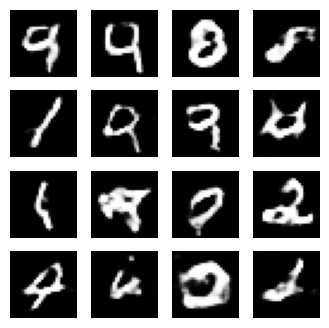

Time for epoch 50 is 23.185615062713623 sec


In [19]:
train(train_dataset, 50)

## Post Training Operations

### Display Image

In [20]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

### Restore model from checkpoint

In [21]:
# Restore the latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Display Gif

In [22]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-22-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-22-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



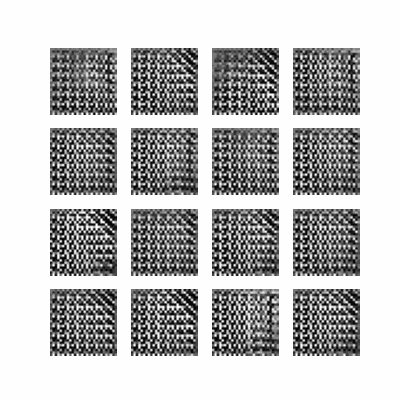

In [23]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)